# Analysis of football match statistics and outcomes

## Initial Aims for exploration:
- Import all matches from 2008 - 2016 including data on:
    - Teams involved
    - Match Outcome
    - Match Stats e.g. shots, possession, bookings etc
    - ID of the players in the match day starting 11 plus their ability ratings
    - Other info that can be engineered that I feel is relevant to match outcome

- MVP: Build a model for match prediction for English Premier League games - based on the team stats e.g. avg goals per game, ratings of players in the starting 11

- Stretch 1 - is the style of win changing (2008 - 2011 Tiki Taka in the ascendancy on the continent; 2013- gegenpressing in Germany). Do the match stats show a difference in manner of victory?

The database is in SQL so we'll use SQLite to bring it in and do some initial analysis on a few tables

In [70]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings

warnings.simplefilter('ignore') # this is to ignore warnings that are not useful

### What is in this database?

There are seven SQL tables available. Reading from the Kaggle Data Card:

- **Country**: We will take England only for the MVP (country id 1729) and we'll use this to join up the English Premier League Matches in the Match table

- **League**: The top tier league in all of the countries in Country are here. 
    - Includes Spain, France, Italy and Germany (with England they make up the top 5 European Leagues) and Scotland among others. We are beginning with just England (league id 1729 like the country id)

- **Match**: 26,000 rows with country id and league id. Other columns include:
    - stage, which presumably is the round in the season e.g. in a 20-team home-and-away season of 38 games, stage 1 is the opening round and 38 is the final game day. Easy to audit this - England is 20 teams and there should be exactly 38 stages in every season

    - Home team and away team identifiers; 

    - home goals & away goals
    
    - **home and away players X and Y coordinates.** I think this is their average position. From just eyeballing this, 1 is the goalkeeper and this is very narrowly defined (because goalkeepers don't move much compared to other positions). It's missing for about 7% of records, probably the earlier seasons in some leagues before it was recorded

    - Key match stats, but data appears to be missing for 45% of records (according to the Kaggle data card):
        - Goals
        - Shot on target
        - shot off target
        - foul committed
        - cards
        - crosses
        - corner
        - possession
    
     
    - Bet 365 odds (B365H / B365D / B365A) - ignore for now, we are trying to do our own and could compare to these *later*
        - Lots of other columns which are for betting providers too. We can ignore for now 
            - BWH, BWD, BWA, 
            - IWH, IWD, IWA, 
            - LBH, LBD, LBA... These all have Home, Draw, Away and I think they are all bookmaker stats

- **Player** - Basic info like DOB, Height, Weight

- **Player_Attributes** - more detailed stats like overall_rating, potential, pref. foot, work rates, crossing, finishing etc. This information is provided from the FIFA video games which gives every player a measure of ability

- **Team** - Very basic identifying info like Name & id for link to other tables

- **Team_Attributes** - more detail around build up play statistics and it is recorded once per year. Also comes from FIFA data
    - is it changing over time?

## What Questions can we answer with a predictive model?

### 1. MVP: Can we predict match outcome? Data columns could include
- **Home & away team,** result which we engineer from home goals & away goals, with winning team id
- **OVR Rating of the starting 11**, coming from Player_attributes via player_api_id.
    - Start with avg OVR rating. Then maybe add OVR rating for Strikers, Goalkeeepers
    
- **For more granular data**, bring in players' work rates, GK overall, overall finishing stats.
    - NOTE: there is no data column for player position. There are too many to label manually, so we could implement a rule based on some of the key player stats to identify this. BY far the easiest will be goalkeeper, and we add OVR rating for that.
    - ANy other granular data for the most likely stats to impact goals scored/conceded, because that's the direct influence on the results


### 2. Stretches  - once we have done the MVP

- How does Height/Weight affect style of play? Taller, bulkier players mean a faster long-ball style of play?

-  Physical vs Technical - which ability set is more important in the winning teams?
    - Physical: Acceleration, Sprint Speed, Agility, Reactions, Balance, Jumping, Stamina, Strength
    - Technical: Crossing, Finishing, Heading Acc., Short Passing, Volleys, Dribbling, Curve, FK Acc., Long Passing, Ball Control
    - Mental: Aggression, Interceptions, Positioning, Vision, Penalties (it's psychological)



## Open the database (pandas)

In [71]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    all_countries = pd.read_sql_query("SELECT * from Country", conn)
    all_matches = pd.read_sql_query("SELECT * from Match", conn)
    all_leagues = pd.read_sql_query("SELECT * from League", conn)
    all_teams = pd.read_sql_query("SELECT * from Team", conn)

In [72]:
selected_countries = ['England'] # leave this format in case we want to add more countries later
countries = all_countries[all_countries.name.isin(selected_countries)] # England id is 1729

# merge leagues - it is only going to be premier league, but incase other leagues are added in the future
leagues = countries.merge(all_leagues, on='id', suffixes=('', '_y')) # suffixes = ('', '_y') is to avoid duplicate columns

In [73]:
# check all columns - more exploration done above and we will remove all the bookies columns soon
all_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [74]:
# get only the relevant columns

matches_prem = all_matches[all_matches.league_id.isin(leagues.id)] 
# Above, we could do league_id == 1729, but this is more flexible when we decide to add more leagues,
# We just add the country name two code cells above and it will work

Below I will **remove the bookmakers odds columns** - they begin with Bet 365 (B365X, where X = H for a bet on the Home team winning; D for Draw, A for Away team, and have many outlets inc. Ladbrookes (LBX), Bet Victor (VCX), William Hill (WHX)) so I will cut off the matches df from the Bet 365 columns onwards.

In [75]:
# 86th column is B365H - remove everything from here onward
matches_prem = matches_prem.iloc[:, :85]

## Initial Data Cleaning & Exploration in Pandas

Initial Look after betting odds columns have been removed:

In [76]:
matches_prem.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,127857.0,34466.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,33633.0,107216.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


### Comments for initial cleaning & EDA

- We don't need the country_id and league_id when we know all of these are Premier League games for the MVP. We can remove these columns, keep the id as the index column.

- We can clean the other columns so it is readable e.g. the match stats look like they've been scraped from HTML. We can parse and extract the important stuff like goals.
- Maybe later, we will feature engineer for last five results to show recent form going into this game (date will be important)

In [77]:
# make a prem df where we drop the country_id and league_id columns
prem = matches_prem.drop(['country_id', 'league_id'], axis=1)


In [78]:
# rename columns to make them more understandable

# rename stage to round / 38 rounds in a premier league season
prem = prem.rename(columns={'stage': 'Round / 38'})

# rename values in season - split the season before and after the / and take the last two characters of both
prem['season'] = prem['season'].apply(lambda x: x.split('/')[0][2:] + '/' + x.split('/')[1][2:])

prem = prem.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# cast the date column to datetime
prem['date'] = pd.to_datetime(prem['date'])

For now we won't use the x and Y coordinates of the players so we will remove those columns

In [79]:
# remove player coordinates more concisely
prem = prem[prem.columns.drop(list(prem.filter(regex='(home|away)_player_(X|Y)[1-9]|(home|away)_player_(X|Y)10|(home|away)_player_(X|Y)11')))]

# cast home_player_1 to home_player_11 to int
# Use a combined regex to match and cast both 'home_player_1' to 'home_player_11' and 'away_player_1' to 'away_player_11' to Int64
prem[prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').columns] = \
    prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').astype('Int64')

In [80]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,home_player_1,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
3622,3623,12/13,9,2012-10-27,1229190,8456,10003,1,0,31432,...,2802,118528,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>43</comment><event...
2277,2278,09/10,24,2010-01-30,658975,8658,8586,1,1,31432,...,30830,30348,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>59</comment><event...
4510,4511,15/16,20,2016-01-03,1988902,8668,8586,1,1,31465,...,174850,194165,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>37</comment><stats...
2685,2686,10/11,27,2011-02-13,840122,8559,8668,2,0,23932,...,30876,25666,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...
3107,3108,11/12,30,2012-03-25,1025810,8659,10261,1,3,24147,...,35411,46700,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...


Notice the data stops in October 2015 - 9 fixtures into the season when Leicester City won!

In [29]:
prem.columns

Index(['id', 'season', 'Round / 38', 'date', 'match_api_id', 'Home ID',
       'Away ID', 'Home GS', 'Away GS', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession'],
      dtype='object')

In [30]:
prem['home_player_1'].sample(5) # spot check for some player IDs later

3170     30622
1926     23027
4688     24579
3537    186054
3727    169756
Name: home_player_1, dtype: Int64

Add a Result column below - positive for home win (+3 means 3 goal victory), 0 for draw, negative for away win

In [31]:
# add the Result Column - 1 if home team wins, 0 if draw, -1 if away team wins
prem.insert(9, 'Result', np.sign(prem['Home GS'] - prem['Away GS']))

# add the Margin column = gives the margin of victory for the home / away team
prem.insert(10, 'Margin', prem['Home GS'] - prem['Away GS'])

In [33]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
3371,3372,12/13,20,2012-12-29,1229309,9879,10003,1,2,-1,...,38831,38759,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>57</comment><event...
4437,4438,15/16,13,2015-11-21,1988839,8659,9825,2,1,1,...,78513,46469,<goal><value><comment>n</comment><stats><goals...,<shoton><value><event_incident_typefk>139</eve...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>32</comment><stats...
1871,1872,08/09,22,2009-01-18,489256,8654,9879,3,1,1,...,31907,24741,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...
3492,3493,12/13,31,2013-03-30,1229434,8456,10261,4,0,1,...,31292,46700,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...
3907,3908,13/14,34,2014-04-12,1475074,8659,8586,3,3,0,...,30960,194165,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>43</comment><event...


So far we have made the results and margin columns, which indicate 1 for a home win, 0 for draw and -1 for home loss.

I think this is a 'base rate' that the model could in future use to predict a result. Let's get some visuals on a very large level how common home vs away wins are.

Text(0.5, 1.0, 'Premier League Results from 3040 games, 08/09 - 15/16')

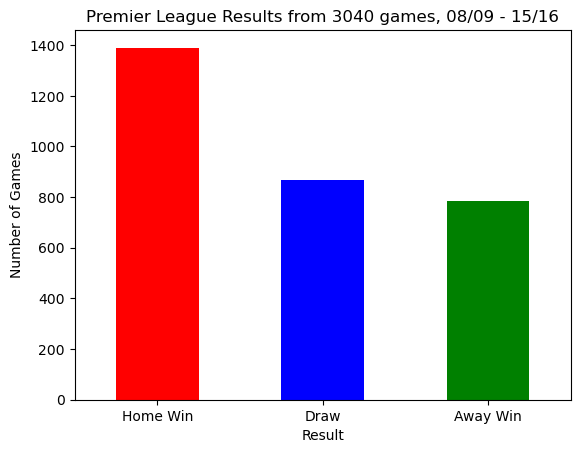

In [46]:
# count the sum total of -1, 0, 1 in the Result column - do not add the values, plot the number of times each result occurs
prem['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])

# 1 = home win, 0 = draw, -1 = away win
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
plt.ylabel('Number of Games')

# title - Premier League Results 200`8/09 - 2015/16
plt.title('Premier League Results from 3040 games, 08/09 - 15/16')


In [54]:
import plotly.express as px

# Count the number of occurrences of each result
result_counts = prem['Result'].value_counts()

# Create labels and calculate the share of total games
labels = ['Home Win', 'Draw', 'Away Win']
values = [result_counts[1], result_counts[0], result_counts[-1]]
total_games = sum(values)
share_percentages = [f"{(value / total_games * 100):.2f}%" for value in values]

# Create a pie chart with labels moved outside
fig = px.pie(
    names=labels,
    values=values,
    title='Premier League Results from 3040 games, 08/09 - 15/16',
    hole=0.33
)

# Update trace settings to position text outside the pie
fig.update_traces(
    text=[f"{label}: {value} games ({share})" for label, value, share in zip(labels, values, share_percentages)],
    textinfo='label+percent',
    textposition='outside'
)

# Show the chart
fig.show()


So we can see that Home Win is the most common result by far, almost twice as common as a draw and also far more likely than an Away Win.

Let's compare these data to Europe, if we want to use this as a base rate before anything  related to specific teams is introduced... Is England unique in this share of the Home team winning?

### Let's explore the HTML of the match stats columns

In [14]:
prem['goal'].iloc[0]

In [931]:
# check the record with id column 4766 in the goal column - a 0-0 draw
prem[prem['id'] == 4766]['goal']

4765    <goal />
Name: goal, dtype: object

In [932]:
# check where it's a 1-0 win just one entry - the last entry in the data
prem['goal'].iloc[-1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>649</event_incident_typefk><coordinates><value>21</value><value>2</value></coordinates><elapsed>54</elapsed><subtype>tap_in</subtype><player1>239807</player1><sortorder>4</sortorder><team>8659</team><id>4910256</id><n>559</n><type>goal</type><goal_type>n</goal_type></value></goal>'

It's very hard to read without seeing the nesting. We can use BeautifulSoup to parse this and see what is actually in here, is it anything more detailed than what we see in the goals scored column already?

In [933]:
from bs4 import BeautifulSoup

# prettify the HTML content from a dataframe
def prettify_column(col):
    soup = BeautifulSoup(col, 'html.parser')
    return soup.prettify()

# Applying the function to the goal column
prem['goal_parsed'] = prem['goal'].apply(prettify_column)

# Now, you can print an example entry to see the formatted HTML
print(prem['goal_parsed'].iloc[0])


<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   406
  </event_incident_typefk>
  <elapsed>
   22
  </elapsed>
  <player2>
   38807
  </player2>
  <subtype>
   header
  </subtype>
  <player1>
   37799
  </player1>
  <sortorder>
   5
  </sortorder>
  <team>
   10261
  </team>
  <id>
   378998
  </id>
  <n>
   295
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <elapsed>
   24
  </elapsed>
  <player2>
   24154
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   24148
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   10260
  </team>
  <id>
   379019
  </id>
  <n>
   298
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



In [934]:
print(prem['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   649
  </event_incident_typefk>
  <coordinates>
   <value>
    21
   </value>
   <value>
    2
   </value>
  </coordinates>
  <elapsed>
   54
  </elapsed>
  <subtype>
   tap_in
  </subtype>
  <player1>
   239807
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   8659
  </team>
  <id>
   4910256
  </id>
  <n>
   559
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



### goal column contains:
- a < goal /> tag if there are no goals

- a value tag for every goal
    - within this value tag, there is a comment tag which has mostly 'n' but also other letters. I don't know the meaning of it yet
    - elapsed, which may be the minute of the game it was scored,
    - **goal subtype** including header, tap-in, good data here!
    - **coordinates** which must be X and Y, e.g. the tap-in has coordinates value 21, 2 (2 yards out from the goal?)
    - team id
    - id which I assume is a goal_id?

I want to extract:
- goal subtype and see what types they have recorded
- comment, to see if it can be entirely ignored if it's just 'n'
- later on, we will get elapsed, assuming this is time the goal was scored

In [935]:
# Function to extract <comment> and <subtype> values, with a check for <value> tags
def extract_comment_and_subtype(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Check if there is a <goal> tag and if it contains <value> tags
    goal_tag = soup.find('goal')
    if not goal_tag or not goal_tag.find_all('value'):
        return [], []  # Return empty lists if <goal> or <value> is not found
    
    # Extract all <comment> and <subtype> values within each <value> tag
    comments = [value_tag.find('comment').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('comment')]
    subtypes = [value_tag.find('subtype').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('subtype')]
    
    return comments, subtypes

# Apply the function to extract <comment> and <subtype> values from the 'goal' column
prem['goal_comments'], prem['goal_subtypes'] = zip(*prem['goal'].apply(extract_comment_and_subtype))

# Flatten the lists and get unique values
unique_comments = set([comment for sublist in prem['goal_comments'] for comment in sublist])
unique_subtypes = set([subtype for sublist in prem['goal_subtypes'] for subtype in sublist])

# Print the unique comments and subtypes
print("Unique Comments:", unique_comments)
print("Unique Subtypes:", unique_subtypes)


Unique Comments: {'o', 'n', 'p', 'psm', 'rp', 'dg', 'npm'}
Unique Subtypes: {'shot', 'loose_ball', 'deflected', 'volley', 'bicycle_kick', 'lob', 'indirect freekick', 'direct_freekick', 'tap_in', 'saved', 'header', 'crossbar', 'backheel', 'missed', 'saved_back_into_play', 'distance', 'post'}


We can see a lot of different subtypes including 'saved' or 'missed' which doesn't make sense. Let's see which fields have those

In [936]:
# check goal_subtypes for entries containing 'missed' and 'saved'
missed = prem[prem['goal_subtypes'].apply(lambda x: 'missed' in x or 'saved' in x)]

missed

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
1769,1770,08/09,13,2008-11-15,489163,9825,10252,0,2,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, o, n]","[saved, shot]"
1886,1887,08/09,23,2009-01-28,489271,8655,8559,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, npm, n]","[shot, shot, shot, saved, shot]"
1951,1952,08/09,3,2008-08-30,489065,8654,8655,4,1,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>68</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o, n, dg, npm, n, n]","[header, shot, shot, saved, shot, shot]"
1953,1954,08/09,3,2008-08-30,489067,8668,8462,0,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, npm, n]","[shot, shot, saved, distance]"
1960,1961,08/09,30,2009-03-21,489335,10261,9825,1,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n]","[saved, header, loose_ball, shot, shot]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,4481,15/16,18,2015-12-26,1988882,8455,9817,2,2,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, o, n, npm]","[volley, shot, missed]"
4482,4483,15/16,18,2015-12-26,1988884,8456,8472,4,1,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>72</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, npm]","[header, distance, header, shot, shot, missed]"
4616,4617,15/16,3,2015-08-23,1988738,8659,8455,2,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value>

I was manually trying to compare the sum of Home GS + Away GS with the number of goal subtypes and there are some inconsistencies where saved and missed are involved. We can:

- spot check some records with those and see if goal has a value of 1 or 0
- run a pandas query for these where the sum of goals should add up to the length of the goal_subtypes list

In [937]:
print(missed['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <coordinates>
   <value>
    23
   </value>
   <value>
    6
   </value>
  </coordinates>
  <elapsed>
   5
  </elapsed>
  <player2>
   103419
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   286119
  </player1>
  <sortorder>
   6
  </sortorder>
  <team>
   8197
  </team>
  <id>
   5581005
  </id>
  <n>
   301
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   80
  </event_incident_typefk>
  <coordinates>
   <value>
    25
   </value>
   <value>
    7
   </value>
  </coordinates>
  <elapsed>
   33
  </elapsed>
  <subtype>
   shot
  </subtype>
  <player1>
   103419
  </player1>
  <sortorder>
   2
  </sortorder>
  <tea

## Pause on Pandas: Bring in key information using SQL to aid the analysis

SQL is going to be a lot easier to bring in information like how many goals on average did a given team score this season, team OVR rating for the season, player OVR ratings etc...

Before going for types of goals, possession etc etc I should be looking at high level team information, which is definitely going to impact the predictive power of the model.

The SQL query to be built is:
- Overall Rating From Player_Attributes, join their name
    - we need code to match the player's OVR ability to the year the match takes place e.g. 2015 match takes the player's 2015 OVR
- Joined by their player_api_id to Match table, which has player ID

In [938]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    # countries = pd.read_sql_query("SELECT England FROM Country", conn) # we don't need it for now, other than country id 1729

    matches = pd.read_sql_query("SELECT * FROM Match WHERE country_id IS 1729", conn)

    # leagues = pd.read_sql_query("SELECT * FROM League", conn) - we don't need this right now

    team = pd.read_sql_query("SELECT * FROM Team", conn)

    team_attr = pd.read_sql_query("""
                                  SELECT Team.team_api_id, team_long_name, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression
                                  FROM Team_Attributes
                                  INNER JOIN Team ON Team.team_api_id = Team_Attributes.team_api_id
                                  """, conn)

    player_attr = pd.read_sql_query("""
                                    SELECT Player.player_api_id, player_name, date, overall_rating 
                                    FROM Player_Attributes 
                                    INNER JOIN Player ON Player.player_api_id = Player_Attributes.player_api_id
                                    """, conn)

    player = pd.read_sql_query("SELECT * FROM Player", conn)

### Preparing the player_attribute table

The goal is to have the player id, their overall rating and the year in which it was assigned. This information will let the player easily be joined in to the matches table with their overall rating which is close to the time of the match in question.
    - We can then later create an average OVR rating of the team in the starting 11.

There are many instances of the same player having a new rating multiple times a year, so we will take an average of the overall rating that was given in each rating across each year.

In [939]:
player_attr[player_attr['player_api_id'] == 23021].head() # before preparation

,player_api_id,player_name,date,overall_rating
21897,23021,Boaz Myhill,2016-02-11 00:00:00,72.0
21898,23021,Boaz Myhill,2015-09-21 00:00:00,72.0
21899,23021,Boaz Myhill,2014-05-16 00:00:00,72.0
21900,23021,Boaz Myhill,2014-03-14 00:00:00,72.0
21901,23021,Boaz Myhill,2013-09-20 00:00:00,72.0


In [940]:
# cast date to datetime
player_attr['date'] = pd.to_datetime(player_attr['date'])

# extract just the year from the date
player_attr['date'] = player_attr['date'].dt.year

In [941]:
# now average the overall_rating for each player for each year, group by player_api_id and date
player_attr = player_attr.groupby(['player_api_id', 'player_name', 'date'])['overall_rating'].mean().reset_index()

# round the overall_rating to 1 decimal place
player_attr['overall_rating'] = player_attr['overall_rating'].round(1)

In [942]:
player_attr.dtypes

player_api_id       int64
player_name        object
date                int32
overall_rating    float64
dtype: object

In [943]:
player_attr.sample(5) # after preparation

,player_api_id,player_name,date,overall_rating
21912,37193,Michel Vorm,2008,70.0
28215,40080,Toni Kallio,2008,64.0
66706,312585,Alan Uryga,2015,59.7
55112,181984,Marco Andreolli,2012,76.0
18049,33685,Mohamed Messoudi,2015,67.5


### Preparing the team_attribute columns

The goal is to have the team statistics for that year that the match took place. We may only bring in the team name but extra columns related to the style of play will be brought in too. 

I dropped buildUpPlayDribbling / chanceCreationDribbling because it only began getting recorded in 2014 - near the end of the data

Other notes:
- It looks like all teams get one annual rating for team_attr, so all we need to process is extract the year

- Spot check West Ham (long ball) vs Arsenal (short possession based) - it appears the **larger values for passing indicate longer passing distance**, e.g. long-ball teams have a larger buildUpPlaySpeed and buildUpPlayPassing

In [944]:
teams[teams['team_api_id'] == 8654]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
31,3463,8654,19.0,West Ham United,WHU


In [945]:
team_attr.sample(5) # before processing

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
880,9830,FC Nantes,2011-02-22 00:00:00,50,50,35,50,35,45,55
362,9938,Dundee United,2014-09-19 00:00:00,60,60,52,55,38,41,40
516,8569,GKS Bełchatów,2012-02-22 00:00:00,52,67,52,73,50,47,45
1315,9873,Valenciennes FC,2012-02-22 00:00:00,49,50,51,60,61,43,57
424,8722,1. FC Köln,2015-09-10 00:00:00,59,65,57,36,71,42,56


In [946]:
team_attr.columns

Index(['team_api_id', 'team_long_name', 'date', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression'],
      dtype='object')

In [947]:
# spot check a team to see how this changes - West Ham United and Arsenal
team_attr[team_attr['team_long_name'].isin(['West Ham United', 'Arsenal'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
70,9825,Arsenal,2010-02-22 00:00:00,66,30,30,45,35,30,40
71,9825,Arsenal,2011-02-22 00:00:00,75,40,40,45,65,50,40
72,9825,Arsenal,2012-02-22 00:00:00,25,32,41,34,30,57,57
73,9825,Arsenal,2013-09-20 00:00:00,30,29,41,55,39,64,54
74,9825,Arsenal,2014-09-19 00:00:00,59,26,28,55,64,51,44
75,9825,Arsenal,2015-09-10 00:00:00,59,30,28,44,46,51,44
1384,8654,West Ham United,2010-02-22 00:00:00,58,30,31,70,50,30,70
1385,8654,West Ham United,2011-02-22 00:00:00,35,35,30,45,45,45,45
1386,8654,West Ham United,2012-02-22 00:00:00,63,64,44,60,55,30,34
1387,8654,West Ham United,2013-09-20 00:00:00,72,73,61,74,32,30,37


In [948]:
# cast date to datetime
team_attr['date'] = pd.to_datetime(team_attr['date'])

# extract just the year from the date
team_attr['date'] = team_attr['date'].dt.year

In [949]:
team_attr.sample(5)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
1062,8479,RC Recreativo,2012,41,54,67,50,23,40,49
959,8540,Palermo,2014,66,37,56,34,63,43,42
1316,9873,Valenciennes FC,2013,49,50,51,76,61,43,57
1202,9869,Real Sporting de Gijón,2014,55,43,68,61,44,36,60
108,8583,AJ Auxerre,2012,64,49,51,63,50,34,45


### Big SQL Query - team match results in England

I want to create a df which has aggregated the win/loss/draw and avg goals scored for all teams in England (where the matches recorded are all from the Premier League).

We will use CASE logic to match the team id only when it is specifically home or away to count the goals scored and the goals per match
We can make it more granular later e.g. home wins/losses, away wins/losses if we want.

We can also adjust the below code to add other leagues for if we wanted to check which teams are most dominant in their leagues.

In [950]:
sql_query = """
SELECT
    Team.team_api_id,
    Team.team_long_name AS name,
    League.name AS league,
    COUNT(Match.id) AS total_matches,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END) AS total_GS,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END) AS total_GA,
    SUM(CASE 
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                ELSE 0 
        END) AS total_wins,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal = Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal = Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_draws,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_losses,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END), 2) AS avg_GS_per_match,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END), 2) AS avg_GA_per_match

FROM Team

LEFT JOIN Match ON Team.team_api_id IN (Match.home_team_api_id, Match.away_team_api_id)

JOIN League ON League.id = Match.league_id

WHERE Team.team_api_id IS NOT NULL AND League.id = 1729

GROUP BY Team.team_long_name

ORDER BY total_wins DESC;
"""

In [951]:
# SQL query run

big_stats = pd.read_sql_query(sql_query, conn)

In [952]:
big_stats

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
1,8455,Chelsea,England Premier League,304,583,286,176,70,58,1.92,0.94
2,8456,Manchester City,England Premier League,304,606,307,175,61,68,1.99,1.01
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
6,8668,Everton,England Premier League,304,439,355,121,100,83,1.44,1.17
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
9,10261,Newcastle United,England Premier League,266,324,422,82,65,119,1.22,1.59


In [953]:
big_stats.dtypes # types look good

team_api_id           int64
name                 object
league               object
total_matches         int64
total_GS              int64
total_GA              int64
total_wins            int64
total_draws           int64
total_losses          int64
avg_GS_per_match    float64
avg_GA_per_match    float64
dtype: object

In [954]:
# close the SQL connection
conn.close()

## Progress Check - SQL and Pandas

We have:

- `player_attr` player overall attribute for every year, which can be summed and averaged in the match data table, with player_api to connect to the team
- `team_attr` team statistics, with team_api_id and the date. If we have issues with nulls, we may want to start with just the 2010 - 2015 or 2016 years as some team attribute data is missing from 2008-2009
- `big_stats` aggregated team results for the 33 teams who have competed in the premier league in this 2008-2016 window
- `prem` which is a modified match table where all of this will be aggregated.

In [955]:
# spot check the team_attr for teams that could be pulled in
team_attr[team_attr['team_long_name'].isin(['Middlesbrough', 'Fulham'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
478,9879,Fulham,2010,60,70,70,70,50,40,35
479,9879,Fulham,2011,50,55,45,55,40,45,35
480,9879,Fulham,2012,48,45,38,62,54,38,38
481,9879,Fulham,2013,52,49,49,56,59,39,39
482,9879,Fulham,2014,52,56,58,41,54,29,28
483,9879,Fulham,2015,52,48,39,54,59,29,30
829,8549,Middlesbrough,2010,70,70,70,70,50,30,70
830,8549,Middlesbrough,2011,66,51,64,64,48,54,44
831,8549,Middlesbrough,2012,60,72,40,56,72,38,42
832,8549,Middlesbrough,2013,60,40,40,56,57,38,42


### Sample Pulse Check for the four dfs

In [956]:
prem.sample(7)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
3220,3221,11/12,7,2011-10-02,1024534,8559,8455,1,5,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, n]","[header, tap_in, distance, tap_in, header, shot]"
3699,3700,13/14,16,2013-12-14,1474535,8344,8659,1,0,1,...,<shoton><value><event_incident_typefk>152</eve...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[header]
2011,2012,08/09,35,2009-05-04,489386,10252,8667,1,0,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>53</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
4233,4234,14/15,3,2014-08-30,1724007,10261,9826,3,3,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>72</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, n]","[loose_ball, deflected, volley, header, loose_..."
3966,3967,13/14,5,2013-09-21,1474207,8659,8472,3,0,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>44</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[loose_ball, volley, shot]"
4186,4187,14/15,25,2015-02-11,1724230,10194,8456,1,4,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, p, n]","[shot, header, header, shot]"
4509,4510,15/16,20,2016-01-03,1988901,9826,8455,0,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>32</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[shot, distance, shot]"


In [957]:
player_attr.sample(7)

,player_api_id,player_name,date,overall_rating
32171,42524,Federico Piovaccari,2007,65.0
6942,25415,David Jones,2011,70.0
68733,415024,Roberto Crivello,2015,60.8
4382,23686,Manuel Almunia,2008,79.0
66674,310836,Pierrick Capelle,2016,69.0
40069,93994,Thomas Ayasse,2012,64.5
23486,37806,Gil Vermouth,2012,68.0


In [958]:
team_attr.sample(7)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
1197,9768,Sporting CP,2015,57,56,42,50,55,60,60
628,9885,Juventus,2014,26,24,64,53,72,23,67
165,9772,SL Benfica,2015,69,53,65,66,54,60,57
511,9764,Gil Vicente FC,2013,46,41,54,52,46,39,57
334,2186,Cracovia,2015,37,38,66,66,33,59,34
1239,9985,Standard de Liège,2013,54,62,55,58,60,45,60
1062,8479,RC Recreativo,2012,41,54,67,50,23,40,49


In [959]:
big_stats.sample(7)

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
15,8466,Southampton,England Premier League,152,216,180,60,40,52,1.42,1.18
18,8655,Blackburn Rovers,England Premier League,152,175,252,42,39,71,1.15,1.66
16,8528,Wigan Athletic,England Premier League,190,200,320,50,52,88,1.05,1.68
19,9850,Norwich City,England Premier League,152,160,253,39,41,72,1.05,1.66
33,9798,Reading,England Premier League,38,43,73,6,10,22,1.13,1.92
24,10172,Queens Park Rangers,England Premier League,114,115,199,22,26,66,1.01,1.75
20,9826,Crystal Palace,England Premier League,114,119,150,37,24,53,1.04,1.32


## Combining the dataframes

The goal is:
- In the Prem dataframe, we can replace the home_player_x and away_player_x which are currently just IDs with overall ability values using player_attr
- We can also add in an average OVR for both team's starting 11
    - later on, other team attributes we want to investigate
- We may want to add the team's avg GS and GA, but might this be a problem of collinearity with the classification result?
- We can then have a target column for classification of 1 (home win), 0 (draw) or -1 (away win)

In [960]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
1824,1825,08/09,18,2008-12-20,489218,9879,8549,3,0,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><elaps...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, n]","[loose_ball, shot]"
4492,4493,15/16,19,2015-12-28,1988894,10260,8455,0,0,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>75</comment><stats...,<goal>\n</goal>\n,[],[]
1874,1875,08/09,22,2009-01-17,489259,8559,10260,0,1,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[header]
1893,1894,08/09,24,2009-02-01,489278,10261,8472,1,1,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>79</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, dg]","[loose_ball, shot]"
2517,2518,10/11,11,2010-11-06,839923,8483,8668,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>66</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, dg]","[direct_freekick, header, shot, shot, shot]"


In [961]:
prem.columns

Index(['id', 'season', 'Round / 38', 'date', 'match_api_id', 'Home ID',
       'Away ID', 'Home GS', 'Away GS', 'Result', 'Margin', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
       'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
       'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6',
       'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10',
       'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments',
       'goal_subtypes'],
      dtype='object')

### Adding Player Ratings and Team statistics to prem df

In [962]:
# Convert the 'date' columns to datetime and extract the year
prem['date'] = pd.to_datetime(prem['date'])
prem['year'] = prem['date'].dt.year

player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr['year'] = player_attr['date'].dt.year

# Function to merge and find the nearest year if an exact match is not available
def merge_with_nearest_year(prem_df, player_attr_df, player_col, rating_col_prefix):
    # Sort player_attr by player_id and year
    player_attr_df = player_attr_df.sort_values(['player_api_id', 'year'])
    
    # Initialize a list to hold the rating data
    ratings = []

    # Iterate over each row in prem_df
    for _, row in prem_df.iterrows():
        player_id = row[player_col]
        match_year = row['year']

        # Filter player_attr for the current player_id
        player_data = player_attr_df[player_attr_df['player_api_id'] == player_id]

        # Find the closest year if there are any records for the player
        if not player_data.empty:
            closest_year = player_data.iloc[(player_data['year'] - match_year).abs().argsort()[:1]].squeeze()
            ratings.append(closest_year['overall_rating'])
        else:
            ratings.append(None)  # Append None if no data is available

    # Add the ratings to the prem_df
    prem_df[rating_col_prefix] = ratings

# Apply the function for home and away players
for n in range(1, 12):
    merge_with_nearest_year(prem, player_attr, f'home_player_{n}', f'home_player_{n}_rating')
    merge_with_nearest_year(prem, player_attr, f'away_player_{n}', f'away_player_{n}_rating')

# adding the team statistics to the prem df
prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Home ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'home_total_matches',
    'avg_GS_per_match': 'home_avg_GS_per_match',
    'avg_GA_per_match': 'home_avg_GA_per_match'
}).drop(columns='team_api_id')

prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Away ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'away_total_matches',
    'avg_GS_per_match': 'away_avg_GS_per_match',
    'avg_GA_per_match': 'away_avg_GA_per_match'
}).drop(columns='team_api_id')

In [963]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
2054,3783,13/14,23,2014-01-28,1474938,9850,10261,0,0,0,...,57.0,67.0,55.0,77.0,152,1.05,1.66,266,1.22,1.59
1336,3065,11/12,27,2012-03-03,1025648,10194,9850,1,0,1,...,46.0,48.0,77.0,61.5,304,1.06,1.32,152,1.05,1.66
9,1738,08/09,1,2008-08-17,489051,8455,8462,4,0,1,...,86.5,83.5,82.0,77.0,304,1.92,0.94,76,0.95,1.62
741,2470,09/10,8,2009-10-03,658680,8602,8462,0,1,-1,...,75.5,69.0,69.0,80.5,114,1.04,1.79,76,0.95,1.62
1550,3279,12/13,12,2012-11-17,1229218,9825,8586,5,2,1,...,85.0,83.5,56.0,79.0,304,1.88,1.05,304,1.58,1.18
2917,4646,15/16,32,2016-04-02,1989027,10194,10003,2,2,0,...,56.0,72.0,64.0,71.0,304,1.06,1.32,190,1.23,1.35
2305,4034,14/15,11,2014-11-09,1724087,8472,8668,1,1,0,...,64.0,89.0,68.5,74.0,304,1.10,1.45,304,1.44,1.17
2637,4366,14/15,7,2014-10-04,1724049,10003,10261,2,2,0,...,72.0,66.0,56.0,67.0,190,1.23,1.35,266,1.22,1.59
388,2117,09/10,1,2009-08-15,658581,10194,8191,2,0,1,...,77.0,55.5,62.0,68.5,304,1.06,1.32,76,0.92,1.78
2531,4260,14/15,32,2015-04-13,1724293,8650,10261,2,0,1,...,61.0,56.0,56.0,60.0,304,1.75,1.11,266,1.22,1.59


It looks quite good - lots and lots of columns that need shaving somehow, but we got these in!

Let's check if any nulls are there.

In [964]:
# check every column for nulls by the columns with the most first
prem.isnull().sum().sort_values(ascending=False).head(20)

away_player_10_rating    8
away_player_2_rating     8
away_player_10           8
away_player_2            8
home_player_8            7
home_player_8_rating     7
home_player_10           7
home_player_2            7
home_player_10_rating    7
away_player_7_rating     7
away_player_5            7
away_player_7            7
home_player_2_rating     7
away_player_5_rating     7
away_player_9_rating     6
away_player_9            6
home_player_7_rating     5
away_player_11           5
home_player_7            5
away_player_11_rating    5
dtype: int64

We can see from the above that there are a handful of empty/null ratings because there's a null in the player_id column itself. e.g. away 10 and away 2 both have 8 nulls in the id and the rating.

There are onyl single digit number of nulls across over 3,000 games. For completeness, we can just fill the nulls ratings with the average of the respective team e.g. if away 10_rating is null, give him the average rating of the team around him.

In [965]:
# fill the home_player_x and away_player_x rating columns, if null, with the mean of the team's overall_rating
for n in range(1, 12):
    # Calculate the mean of the other players' ratings for the home team, each row
    home_rating_cols = [f'home_player_{i}_rating' for i in range(1, 12) if i != n] # if i != n is to exclude the current player in case the null is here
    prem[f'home_player_{n}_rating'] = prem.apply(
        lambda row: row[home_rating_cols].mean() if pd.isnull(row[f'home_player_{n}_rating']) else row[f'home_player_{n}_rating'],
        axis=1
    ) # for every row, run through the home player ratings and take the mean if the rating is null

    # same for away team
    away_rating_cols = [f'away_player_{i}_rating' for i in range(1, 12) if i != n]
    prem[f'away_player_{n}_rating'] = prem.apply(
        lambda row: row[away_rating_cols].mean() if pd.isnull(row[f'away_player_{n}_rating']) else row[f'away_player_{n}_rating'],
        axis=1
    )

In [966]:
# check for nulls again - only the IDs, not the ratings!
prem.isnull().sum().sort_values(ascending=False).head()

away_player_2     8
away_player_10    8
away_player_5     7
home_player_2     7
away_player_7     7
dtype: int64

In [967]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
1029,2758,10/11,33,2011-04-26,840183,10194,8602,3,0,1,...,46.0,54.5,62.0,68.5,304,1.06,1.32,114,1.04,1.79
2394,4123,14/15,2,2014-08-24,1723996,8667,10194,1,1,0,...,63.0,56.0,67.0,67.0,152,0.95,1.60,304,1.06,1.32
590,2319,09/10,29,2010-03-08,659098,8528,8650,1,0,1,...,73.0,80.5,79.0,87.0,190,1.05,1.68,304,1.75,1.11
636,2365,09/10,32,2010-03-27,659135,8667,9879,2,0,1,...,65.5,77.0,63.5,71.0,152,0.95,1.60,228,1.16,1.40
313,2042,08/09,38,2009-05-24,489416,8654,8549,2,1,1,...,73.0,78.5,60.0,66.0,266,1.23,1.44,38,0.74,1.50
936,2665,10/11,25,2011-02-02,840101,8483,8654,1,3,-1,...,56.0,85.0,63.0,74.5,38,1.45,2.05,266,1.23,1.44
2159,3888,13/14,32,2014-03-29,1475050,8659,8344,3,3,0,...,64.5,80.0,53.0,74.0,266,1.15,1.52,38,0.84,1.95
2178,3907,13/14,34,2014-04-13,1475073,10003,8455,0,1,-1,...,67.0,65.0,56.0,65.0,190,1.23,1.35,304,1.92,0.94
771,2500,10/11,10,2010-10-30,839905,9825,8654,1,0,1,...,80.0,74.0,80.0,74.5,304,1.88,1.05,266,1.23,1.44
521,2250,09/10,22,2010-01-16,658947,10194,8650,1,1,0,...,67.0,83.5,78.5,61.0,304,1.06,1.32,304,1.75,1.11


## Joins and merges complete - Further cleaning & Feature Engineering of the prem dataframe

### Summary so far and plans ahead:

We have created a master `prem` dataframe which has all the matches from 08/09 to 15/16. Columns of value include
- Match data such as:
    - Team IDs, 
    - date of the fixture,
    - match week of 38. Probably not relevant for predicting the result, but maybe for details match stats later.

- Player data for the home and away players such as:
    - Individual player's overall ratings on both teams, that are recent to the match date

- Team data for the home and away team such as:
    - Team's total number of matches in the league in the reference period. 
    - Teams avg goals scored (GS) and goals against (GA) per game in the time window.
    - These might be a complicated one because that's gathering future information if we are predicting a game early on in the time window.
    
- Details match information like shots, types of goal scored, possession, bookings etc etc but these are heavily nested in columns which we need to dig out later.

Now we can clean a number of unneccessary columns and add one important one:
- Create an average 'team' rating for each match. I think this will be the best way to construct a simple model with some predictive power before complicating things with 22 individual player ratings.

- Remove the individual player IDs, match_api_id

- **For now** remove the Round / 38 aka gameweek, home and away_total matches


### Removing currently (MVP) unnecessary columns

In [968]:
# drop the Round / 38 column, match_api_id, home_total_matches, away_total_matches, year
prem = prem.drop(['Round / 38', 'match_api_id', 'home_total_matches', 'away_total_matches', 'year'], axis=1)

In [969]:
# drop the home/away_player_X columns but NOT the ratings
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]$|^(home|away)_player_10$|^(home|away)_player_11$').columns, axis=1)

In [970]:
# remove the match detail columns - goal, shoton, shotoff, foulcommit, card, cross, corner, possession, goal_parsed, goal_comments, goal_subtypes
prem = prem.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments', 'goal_subtypes'], axis=1)

In [971]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home_player_11_rating',
       'away_player_11_rating', 'home_avg_GS_per_match',
       'home_avg_GA_per_match', 'away_avg_GS_per_match',
       'away_avg_GA_per_match'],
      dtype='object')

### Creating a home and away team match-day overall rating

In [972]:
# Calculate the average overall rating for the home team players
home_rating_cols = [f'home_player_{n}_rating' for n in range(1, 12)]
prem['home_avg_rating'] = prem[home_rating_cols].mean(axis=1)

# Calculate the average overall rating for the away team players
away_rating_cols = [f'away_player_{n}_rating' for n in range(1, 12)]
prem['away_avg_rating'] = prem[away_rating_cols].mean(axis=1)

In [974]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home_player_11_rating',
       'away_player_11_rating', 'home_avg_GS_per_match',
       'home_avg_GA_per_match', 'away_avg_GS_per_match',
       'away_avg_GA_per_match', 'home_avg_rating', 'away_avg_rating'],
      dtype='object')

In [977]:
prem.sample(10)

,id,season,date,Home ID,Away ID,Home GS,Away GS,Result,Margin,home_player_1_rating,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_avg_GS_per_match,home_avg_GA_per_match,away_avg_GS_per_match,away_avg_GA_per_match,home_avg_rating,away_avg_rating
2448,4177,14/15,2015-02-07,8586,9825,2,1,1,1,72.0,...,67.0,70.0,58.0,56.0,1.58,1.18,1.88,1.05,62.272727,66.000000
2360,4089,14/15,2014-12-20,10252,10260,1,1,0,0,66.0,...,56.0,85.5,74.0,65.0,1.10,1.52,1.91,0.92,61.363636,73.045455
573,2302,09/10,2010-02-21,8655,8559,3,0,1,3,83.5,...,81.5,82.5,63.0,77.5,1.15,1.66,1.19,1.66,69.681818,71.636364
79,1808,08/09,2008-12-06,8667,8549,2,1,1,1,66.0,...,76.5,78.5,74.0,79.0,0.95,1.60,0.74,1.50,68.227273,70.863636
1208,2937,11/12,2011-12-10,10003,9879,2,0,1,2,70.0,...,71.0,71.0,76.0,83.0,1.23,1.35,1.16,1.40,66.550000,74.409091
842,2571,10/11,2010-12-11,8654,8456,1,3,-1,-2,76.5,...,74.5,81.0,74.0,78.0,1.23,1.44,1.99,1.01,73.363636,77.363636
275,2004,08/09,2009-04-26,8655,8528,2,0,1,2,83.5,...,71.0,76.5,84.5,73.0,1.15,1.66,1.05,1.68,78.636364,73.000000
950,2679,10/11,2011-02-12,10260,8456,2,1,1,1,86.0,...,85.5,72.0,91.5,87.5,1.91,0.92,1.99,1.01,80.045455,77.681818
449,2178,09/10,2009-12-05,9825,10194,2,0,1,2,74.0,...,85.0,78.5,83.0,67.0,1.88,1.05,1.06,1.32,77.090909,69.454545
76,1805,08/09,2008-12-06,9879,8456,1,1,0,0,78.0,...,83.0,79.0,75.0,75.0,1.16,1.40,1.99,1.01,75.681818,75.363636


### drop the individual player ratings to simplify the df for now

In [982]:
# drop the home/away_player_X_rating columns
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]_rating$|^(home|away)_player_10_rating$|^(home|away)_player_11_rating$').columns, axis=1)

Home / Away net goals - this should standardize around 0 for teams that score and concede equally, and negative for 'weak' teams while positive for 'good' teams

In [983]:
# create a new net goals column for both teams: home_avg_GS_per_match - home_avg_GA_per_match and away_avg_GS_per_match - away_avg_GA_per_match
prem['home_net_goals'] = prem['home_avg_GS_per_match'] - prem['home_avg_GA_per_match']
prem['away_net_goals'] = prem['away_avg_GS_per_match'] - prem['away_avg_GA_per_match']

In [985]:
# drop the home_avg_GS_per_match, home_avg_GA_per_match, away_avg_GS_per_match, away_avg_GA_per_match
prem = prem.drop(['home_avg_GS_per_match', 'home_avg_GA_per_match', 'away_avg_GS_per_match', 'away_avg_GA_per_match'], axis=1)

In [986]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'home_avg_rating', 'away_avg_rating',
       'home_net_goals', 'away_net_goals'],
      dtype='object')

In [987]:
# reorganize the dataframe: id, season, date, home team stats, away team stats, result, margin
prem = prem[['id', 'season', 'date', 'Home ID', 'home_avg_rating', 'home_net_goals', 'Away ID', 'away_avg_rating', 'away_net_goals', 'Result', 'Margin']]

In [988]:
prem

,id,season,date,Home ID,home_avg_rating,home_net_goals,Away ID,away_avg_rating,away_net_goals,Result,Margin
0,1729,08/09,2008-08-17,10260,82.500000,0.99,10261,75.727273,-0.37,0,0
1,1730,08/09,2008-08-16,9825,75.772727,0.83,8659,70.363636,-0.37,1,1
2,1731,08/09,2008-08-16,8472,73.590909,-0.35,8650,79.909091,0.64,-1,-1
3,1732,08/09,2008-08-16,8654,77.045455,-0.21,8528,72.909091,-0.63,1,1
4,1733,08/09,2008-08-17,10252,76.636364,-0.42,8456,70.050000,0.98,1,2
...,...,...,...,...,...,...,...,...,...,...,...
3035,4764,15/16,2015-10-17,8466,63.636364,0.24,8197,66.318182,0.30,0,0
3036,4765,15/16,2015-10-19,10003,61.909091,-0.12,10194,63.181818,-0.26,-1,-1
3037,4766,15/16,2015-10-17,8586,62.363636,0.40,8650,62.227273,0.64,0,0
3038,4767,15/16,2015-10-17,9817,64.227273,-0.27,9825,70.272727,0.83,-1,-3


This is looking good! You can already eyeball a few predictions - the gap in net_goals between home and away, the gap in avg_rating for home and away